In [1]:
import os
import time
import torch

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from models import ShallowNN
from utils import load_file, get_all_possible_pairs
from evals import evaluate, pairwise_euclidean_distance , influence

features = 197
batch_size = 64
loss_fn = torch.nn.L1Loss()

In [2]:
client_ids = ["0_0","0_1","0_2","0_3","0_4","0_5","1_0","1_1","1_2","1_3","1_4","1_5","2_0","2_1","2_2","2_3","2_4","2_5","3_0","3_1","3_2","3_3","3_4","3_5"]

In [3]:
#fed_learning_all_losses = pd.read_csv("losses/fed_learning_stats_64.csv")

In [4]:
"""
fig,axes = plt.subplots(nrows=4,ncols=6,figsize=(60, 30))
for client in client_ids:
    plot_id = client.split("_")
    fed_losses = fed_learning_all_losses.loc[fed_learning_all_losses['client_id'] == client].reset_index().drop(columns=['index','training_round','client_id','fed_train'])
    fed_losses = fed_losses.rename(columns={"validation_loss": "fed_val"})
    iso_losses = pd.read_csv("losses/batch64_client_"+str(client)+".csv").drop(columns=["iso_train"])
    df = pd.concat([fed_losses, iso_losses], axis=1)
    df.plot(ax=axes[int(plot_id[0])][int(plot_id[1])],title=client)
"""

'\nfig,axes = plt.subplots(nrows=4,ncols=6,figsize=(60, 30))\nfor client in client_ids:\n    plot_id = client.split("_")\n    fed_losses = fed_learning_all_losses.loc[fed_learning_all_losses[\'client_id\'] == client].reset_index().drop(columns=[\'index\',\'training_round\',\'client_id\',\'fed_train\'])\n    fed_losses = fed_losses.rename(columns={"validation_loss": "fed_val"})\n    iso_losses = pd.read_csv("losses/batch64_client_"+str(client)+".csv").drop(columns=["iso_train"])\n    df = pd.concat([fed_losses, iso_losses], axis=1)\n    df.plot(ax=axes[int(plot_id[0])][int(plot_id[1])],title=client)\n'

In [5]:
global_model = ShallowNN(features)
global_model.load_state_dict(torch.load('checkpt/_fedl_global_500.pth'))

<All keys matched successfully>

In [6]:
eval_list = []
for client in client_ids:
    
    val_data_path =  "testpt/"+str(client)+".pt"
    val_set = torch.load(val_data_path)
    val_loader = DataLoader(val_set, batch_size, shuffle = True)
    
    isolated_model_path = "checkpt/isolated/batch64_client_"+str(client)+".pth"
    isolated_model =  ShallowNN(features)
    isolated_model.load_state_dict(torch.load(isolated_model_path))
    
    _, _ , isolated_mae = evaluate(isolated_model, val_loader, loss_fn)
    _, _ , global_mae = evaluate(global_model,val_loader,loss_fn)
    
    eval_dict = {"client_id":client, "Isolated Model MAE": round(isolated_mae, 4), "Federated Model MAE" :round(global_mae, 4)}
    eval_list.append(eval_dict)
    
eval_df = pd.DataFrame.from_dict(eval_list)
eval_df["clients"] = [i for i in range(1,25)] 

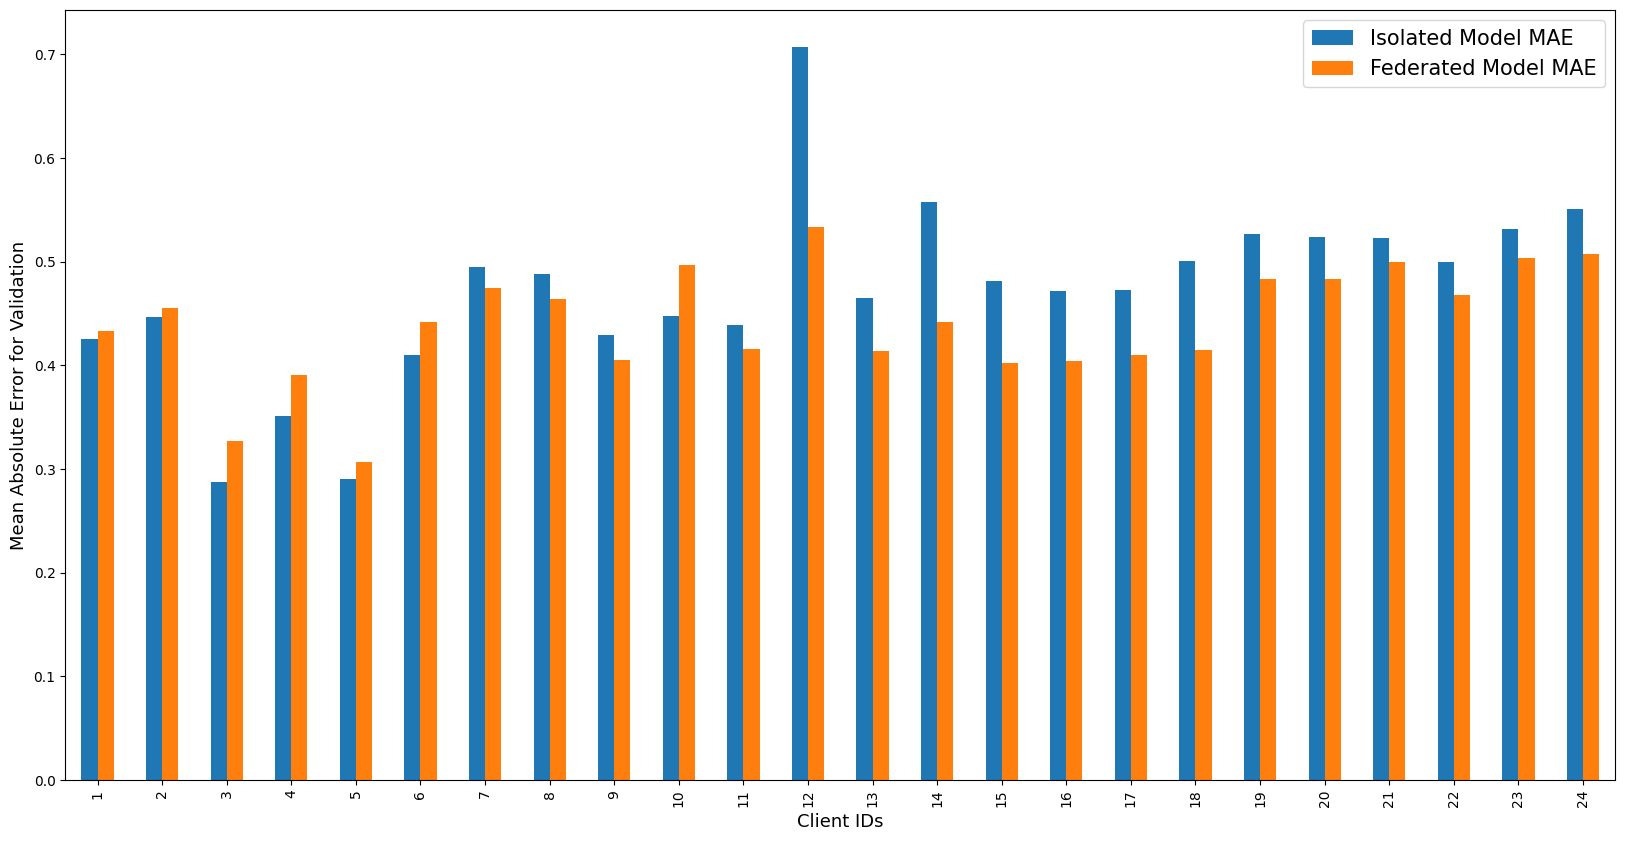

In [7]:
ax = eval_df.plot.bar(x="clients",figsize=(20, 10))
ax.set_ylabel("Mean Absolute Error for Validation",fontdict={'fontsize':13})
ax.set_xlabel("Client IDs",fontdict={'fontsize':13})
ax.legend(fontsize=15, loc="upper right")

In [9]:
ben_list = []
for index, row in eval_df.iterrows():
    ben_list.append(round(row['Isolated Model MAE']-row['Federated Model MAE'],4))
eval_df["Benefict"] = ben_list

In [19]:
eval_df.to_csv("insights/benifict.csv", index= False)

<Axes: xlabel='clients'>

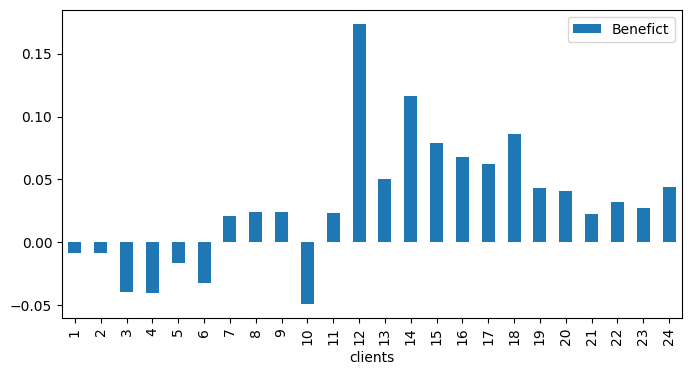

In [11]:
eval_df.plot.bar(x="clients",y="Benefict", figsize=(8, 4))

In [22]:
def influence(global_model, influenced_model):
    eval_list = []
    for client in client_ids:

        val_data_path =  "testpt/"+str(client)+".pt"
        val_set = torch.load(val_data_path)
        val_loader = DataLoader(val_set, batch_size, shuffle = True)

        _, _ , global_mae = evaluate(global_model,val_loader,loss_fn)
        _, _ , influenced_mae = evaluate(influenced_model, val_loader, loss_fn)

        eval_dict = {"client_id":client, "global_mae": round(global_mae, 4), "influenced_mae" :round(influenced_mae, 4)}
        eval_list.append(eval_dict)

    eval_df = pd.DataFrame.from_dict(eval_list)
    influence = round(eval_df["global_mae"].sum() - eval_df["influenced_mae"].sum() , 4)
    return eval_df, influence

In [24]:
#client_ids = ["0_0","0_1","0_2","0_3","0_4","0_5"]
inf_val = []
for client in client_ids:
    model = ShallowNN(features)
    model.load_state_dict(torch.load('checkpt/influence/' + str(client)+ '_fedl_global_500.pth'))
    df, inf = influence(global_model,model)
    inf_val.append(inf)
    #df.to_csv("influence2_"+str(client) + ".csv", index=False)
data = {"client id": client_ids, "inf_val": inf_val}
data = pd.DataFrame(data)
data.to_csv("insights/influence_with_batch_mae.csv" , index=False)

In [ ]:
global_model = ShallowNN(features)
global_model.load_state_dict(torch.load('checkpt/_fedl_global_500.pth'))

def hessian(client):
    
    val_dataset = torch.load("trainpt/"+ str(client)+".pt")
    validation_data_loader = DataLoader(val_dataset, batch_size, shuffle=True)
    
    isolated_model = ShallowNN(features)
    isolated_model_path = "checkpt/isolated/batch64_client_"+str(client)+".pth"
    isolated_model.load_state_dict(torch.load(isolated_model_path))
                                              
    fed_hessian_mat , _  = calculate_hessian_flattened(global_model,loss_fn,validation_data_loader)
    iso_hessian_mat , _ = calculate_hessian_flattened(isolated_model,loss_fn,validation_data_loader)
    
    return fed_hessian_mat, iso_hessian_mat

In [ ]:
for client in client_ids:
    fed_hessian_mat , iso_hessian_mat = hessian(client)
    torch.save(fed_hessian_mat, "hessians/fed/"+str(client)+".pth")
    torch.save(iso_hessian_mat, "hessians/iso/"+str(client)+".pth")
    print("Client " +str(client)+ " done.")

In [ ]:
fed_hessian_mat , iso_hessian_mat = hessian("0_0")

In [ ]:
torch.save(fed_hessian_mat, "hessians/fed/"+str("0_0")+".pth")
loaded_matrix = torch.load("hessians/fed/"+str("0_0")+".pth")

In [ ]:
from evals import euclidean_distance, pairwise_euclidean_distance, accumulated_proximity, full_accumulated_proximity

In [ ]:
full_acc_proximity = full_accumulated_proximity(client_ids)

In [27]:
for client in client_ids:
    fed_matrix = torch.load("hessians/fed/" + str(client) + ".pth")
    iso_matrix = torch.load("hessians/iso/" + str(client) + ".pth")
    acc_proximity = accumulated_proximity(fed_matrix,iso_matrix,euclidean_distance)
    
    print(client,acc_proximity, acc_proximity/full_acc_proximity)

NameError: name 'accumulated_proximity' is not defined